Приложение по доставке продуктов.
<br> Команда внедрила в приложение умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

<br> Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

<br> Задача – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.


<br> Логи заказов пользователей:
<br> ab_users_data – история заказов пользователей, в этой таблице есть
информация о том, какие заказы создавали и отменяли пользователи
<br> ab_orders – подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов, которые были включены в заказ
<br> ab_products – подробная информация о продуктах, их название и стоимость

In [153]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg #(необходимо установить pip install pingouin)
import requests
import os
import uuid
import scipy.stats as stats
import statsmodels.stats.api as sms
import warnings
from scipy.stats import shapiro, levene, ks_2samp, ttest_ind, chi2_contingency
from scipy.stats import mannwhitneyu
from IPython.display import display_html
from itertools import chain,cycle

In [154]:
# Напишем функцию для загрузки исходных данных

def download_file(url, sep_type):
    main_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?public_key='
    file_url = requests.get(main_url + url).json()['href'] # 'парсинг' ссылки на скачивание
    file = requests.get(file_url)

    # Создаем уникальное имя для файла
    unique_filename = f"file_{uuid.uuid4()}.csv"
    file_path = os.path.join('/tmp', unique_filename)

    # Сохраняем файл
    with open(file_path, 'wb') as f:
        f.write(file.content)

    df = pd.read_csv(file_path, sep=sep_type)
    os.remove(file_path)

    return df

In [155]:
# Подгружаем данные
ab_users_data = download_file(url='https://disk.yandex.ru/d/4qY27tJ23G_B1g', sep_type=',')
ab_orders     = download_file(url='https://disk.yandex.ru/d/prdO8FDQx7lzCg', sep_type=',')
ab_products   = download_file(url='https://disk.yandex.ru/d/atwrlmB_wu-fHA', sep_type=',')

In [156]:
# Функция для красивой отрисовки всех таблиц
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str += '<th style="text-align:center"><td style="vertical-align:top">'
        html_str += f'<h2 style="text-align: center;">{title}</h2>'
        html_str += df.to_html().replace('table','table style="display:inline"')
        html_str += '</td></th>'
    display_html(html_str,raw=True)

In [157]:
# Создаем таблицу для удобного отображения всех данных
display_side_by_side(ab_users_data.head(), ab_orders.head(), ab_products.head(),
                    titles=['ab_users_data', 'ab_orders', 'ab_products'])

ab_users_data 
 
 
 
 user_id 
 order_id 
 action 
 time 
 date 
 group 
 
 
 
 
 0 
 964 
 1255 
 create_order 
 2022-08-26 00:00:19.000000 
 2022-08-26 
 0 
 
 
 1 
 965 
 1256 
 create_order 
 2022-08-26 00:02:21.000000 
 2022-08-26 
 1 
 
 
 2 
 964 
 1257 
 create_order 
 2022-08-26 00:02:27.000000 
 2022-08-26 
 0 
 
 
 3 
 966 
 1258 
 create_order 
 2022-08-26 00:02:56.000000 
 2022-08-26 
 0 
 
 
 4 
 967 
 1259 
 create_order 
 2022-08-26 00:03:37.000000 
 2022-08-26 
 1 
 
 
 ab_orders 
 
 
 
 order_id 
 creation_time 
 product_ids 
 
 
 
 
 0 
 1255 
 2022-08-26 00:00:19.000000 
 {75, 22, 53, 84} 
 
 
 1 
 1256 
 2022-08-26 00:02:21.000000 
 {56, 76, 39} 
 
 
 2 
 1257 
 2022-08-26 00:02:27.000000 
 {76, 34, 41, 38} 
 
 
 3 
 1258 
 2022-08-26 00:02:56.000000 
 {74, 6} 
 
 
 4 
 1259 
 2022-08-26 00:03:37.000000 
 {20, 45, 67, 26} 
 
 
 ab_products 
 
 
 
 product_id 
 name 
 price 
 
 
 
 
 0 
 1 
 сахар 
 150.0 
 
 
 1 
 2 
 чай зеленый в пакетиках 
 50.0 
 
 
 2 
 3 
 вода негазированная 
 80.4 
 
 
 3 
 4 
 леденцы 
 45.5 
 
 
 4 
 5 
 кофе 3 в 1 
 15.0

In [158]:
# Смотрим на количество данных
print(ab_users_data.shape, ab_orders.shape, ab_products.shape)

(4337, 6) (4123, 3) (87, 3)


In [159]:
# Заметим, что количество строчек в таблице ab_users_data больше, чем в ab_orders
ab_users_data['action'].unique()

array(['create_order', 'cancel_order'], dtype=object)

Как мы видим, это связано с тем что статус заказа имеет два состояния: создан (create_order) и отменен (cancel_order)

# Гипотеза №1: Изменилось ли количество заказов

In [160]:
# Посмотрим на распределние числа заказов по группам без учета отмененных
user_orders = ab_users_data.query('action != "cancel_order"')
user_orders.groupby('group', as_index=False)['order_id'].count()

,group,order_id
0,0,1609
1,1,2514


In [161]:
# А теперь в разбивке по юзерам
user_orders_check = user_orders.groupby(['group', 'user_id'], as_index=False).size()
user_orders_check.head()

,group,user_id,size
0,0,964,2
1,0,966,1
2,0,968,3
3,0,969,2
4,0,972,1


<Axes: xlabel='size', ylabel='count'>

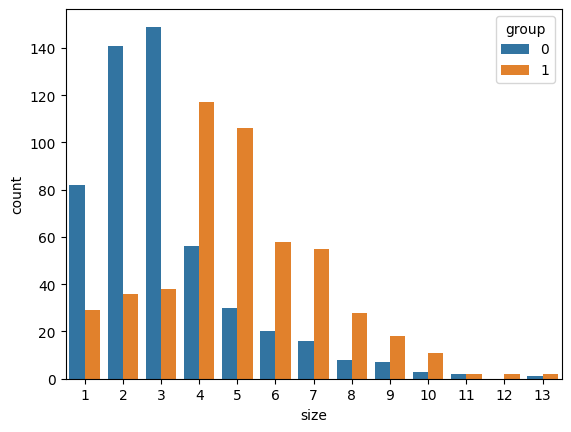

In [162]:
sns.countplot(data=user_orders_check, x='size', hue='group')

In [163]:
pg.ttest(user_orders_check[user_orders_check['group'] == 0]['size'], \
         user_orders_check[user_orders_check['group'] == 1]['size'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-14.485157,988.435475,two-sided,2.907783e-43,"[-2.14, -1.63]",0.910119,7.663e+39,1.0


Видно, что p-value < 0.05, следовательно различия есть (примерно 2 заказа на пользователя)

In [164]:
pg.mwu(user_orders_check[user_orders_check['group'] == 0]['size'], \
         user_orders_check[user_orders_check['group'] == 1]['size'])

,U-val,alternative,p-val,RBC,CLES
MWU,61172.5,two-sided,6.987140e-49,0.526767,0.236617


p-value также значительно меньше < 0.05. Показатель CLES характеризует вероятность взять случайного пользователя из первой группы и сравнить количество заказов с случайным пользователем со второй группы

# Гипотеза №2: Изменилась пропорция отмен

In [165]:
# Создадим столбец, который показывает был ли отменен заказ или нет
ab_users_data['is_canceled'] = ab_users_data['action'].apply(lambda x: 1 if x == 'cancel_order' else 0)

In [166]:
pd.crosstab(ab_users_data['group'], ab_users_data['is_canceled'])

is_canceled,0,1
group,,
0,1609,82
1,2514,132


In [167]:
expected, observed, stats = pg.chi2_independence(data=ab_users_data, x='group', y='is_canceled')
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.018211,1.0,0.892652,0.002049,0.052089
1,cressie-read,0.666667,0.018219,1.0,0.892629,0.002050,0.052090
2,log-likelihood,0.000000,0.018235,1.0,0.892583,0.002050,0.052091
3,freeman-tukey,-0.500000,0.018247,1.0,0.892548,0.002051,0.052093
4,mod-log-likelihood,-1.000000,0.018259,1.0,0.892513,0.002052,0.052094
5,neyman,-2.000000,0.018283,1.0,0.892442,0.002053,0.052097


Видно, что p-value почти достигает 90 процентов. Это означает, что увеличение числа отмен заказов связано с увеличением числа заказов  

# Гипотеза №3: Изменилось число позиций в заказе

In [168]:
# Объединяем данные пользователей и заказов
users_orders = pd.merge(ab_users_data, ab_orders, how='left', on='order_id')
users_orders.drop(columns=['time'], inplace=True)
users_orders.head()

,user_id,order_id,action,date,group,is_canceled,creation_time,product_ids
0,964,1255,create_order,2022-08-26,0,0,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,965,1256,create_order,2022-08-26,1,0,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,964,1257,create_order,2022-08-26,0,0,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,966,1258,create_order,2022-08-26,0,0,2022-08-26 00:02:56.000000,"{74, 6}"
4,967,1259,create_order,2022-08-26,1,0,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [169]:
# Преобразуем product_ids каждую строку в массив
users_orders['product_ids'] = users_orders['product_ids'].str.strip("{}").str.split(",")
users_orders = users_orders.explode('product_ids')

In [170]:
users_orders.head()

,user_id,order_id,action,date,group,is_canceled,creation_time,product_ids
0,964,1255,create_order,2022-08-26,0,0,2022-08-26 00:00:19.000000,75
0,964,1255,create_order,2022-08-26,0,0,2022-08-26 00:00:19.000000,22
0,964,1255,create_order,2022-08-26,0,0,2022-08-26 00:00:19.000000,53
0,964,1255,create_order,2022-08-26,0,0,2022-08-26 00:00:19.000000,84
1,965,1256,create_order,2022-08-26,1,0,2022-08-26 00:02:21.000000,56


In [171]:
order_products = users_orders.query("is_canceled == 0").groupby(["group", "order_id"], as_index=False).size()
order_products.head()

,group,order_id,size
0,0,1255,4
1,0,1257,4
2,0,1258,2
3,0,1261,4
4,0,1262,4


<Axes: xlabel='size', ylabel='count'>

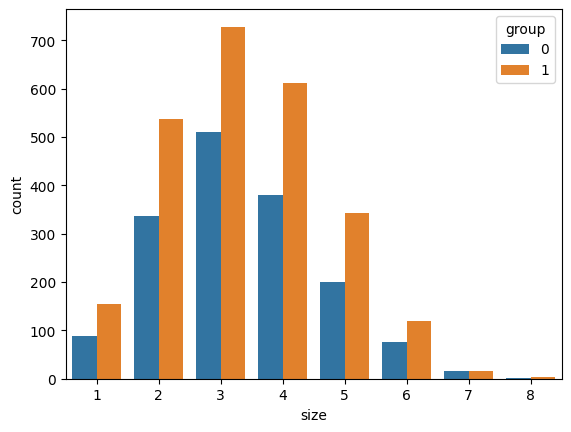

In [172]:
sns.countplot(data=order_products, x="size", hue='group')

In [173]:
pg.ttest(order_products[order_products['group'] == 0]['size'], \
         order_products[order_products['group'] == 1]['size'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.138556,3469.224056,two-sided,0.889809,"[-0.09, 0.07]",0.004407,0.036,0.052185


In [174]:
pg.mwu(order_products[order_products['group'] == 0]['size'], \
         order_products[order_products['group'] == 1]['size'])

,U-val,alternative,p-val,RBC,CLES
MWU,2013211.0,two-sided,0.79766,0.004599,0.4977


T-тест и тест Манна Уитни показывают, что различий нет

# Гипотеза №4: Изменилась ли выручка

In [177]:
users_orders['product_ids'] = users_orders['product_ids'].astype(np.int64)

In [178]:
# Объединяем данные о продуктах к итоговой таблице
order_prices = pd.merge(users_orders, ab_products, how='left', left_on='product_ids', right_on='product_id')
order_prices.head()

,user_id,order_id,action,date,group,is_canceled,creation_time,product_ids,product_id,name,price
0,964,1255,create_order,2022-08-26,0,0,2022-08-26 00:00:19.000000,75,75,сок ананасовый,120.0
1,964,1255,create_order,2022-08-26,0,0,2022-08-26 00:00:19.000000,22,22,сок мультифрукт,120.0
2,964,1255,create_order,2022-08-26,0,0,2022-08-26 00:00:19.000000,53,53,мука,78.3
3,964,1255,create_order,2022-08-26,0,0,2022-08-26 00:00:19.000000,84,84,мандарины,90.4
4,965,1256,create_order,2022-08-26,1,0,2022-08-26 00:02:21.000000,56,56,сосиски,150.0


In [182]:
prices_group = order_prices.groupby(["group", "order_id"], as_index=False).agg({"price": "sum"})
prices_group.head()

,group,order_id,price
0,0,1255,408.7
1,0,1257,310.2
2,0,1258,170.0
3,0,1261,430.7
4,0,1262,358.6


<Axes: xlabel='price', ylabel='Count'>

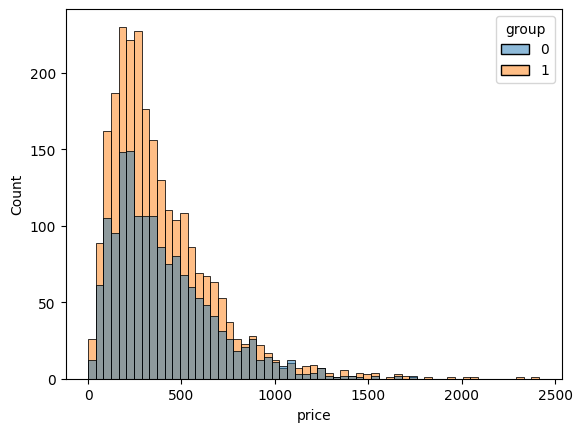

In [187]:
sns.histplot(data=prices_group, x='price', hue='group')

In [188]:
pg.ttest(prices_group[prices_group['group'] == 0]['price'], \
         prices_group[prices_group['group'] == 1]['price'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.166299,3544.943051,two-sided,0.243572,"[-6.95, 27.35]",0.036848,0.071,0.211024


In [189]:
pg.mwu(prices_group[prices_group['group'] == 0]['price'], \
         prices_group[prices_group['group'] == 1]['price'])

,U-val,alternative,p-val,RBC,CLES
MWU,2092667.0,two-sided,0.059894,-0.034687,0.517343


# Вывод:

Из всех выдвинутых гипотез, только первая показала статистически значимые различия. Но она также является ключевой. Поэтому можно сделать вывод, что новая система рекомендаций может принести пользу бизнесу и пользователям приложения.

